<a href="https://colab.research.google.com/github/VishwasMore/face-detection/blob/main/Network_architecture_and_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# End-to-end Facial Keypoint Detection Book 2

## Define the network Architecture

1. Define a CNN with images as input and keypoints as output
2. Construct the transformed FaceKeypointsDataset, just as before
3. Train the CNN on the training data, tracking loss
4. See how the trained model performs on test data
5. If necessary, modify the CNN structure and model hyperparameters, so that it performs *well* **\***

**\*** What does *well* mean?

"Well" means that the model's loss decreases during training **and**, when applied to test image data, the model produces keypoints that closely match the true keypoints of each face. And you'll see examples of this later in the notebook.

In [15]:
# import the usual resources
import matplotlib.pyplot as plt
import numpy as np

# watch for any changes in model.py, if it changes, re-load it automatically
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
## Define the network Architecture

import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
# can use the below import should you choose to initialize the weights of your Net
import torch.nn.init as I

class Net(nn.Module):
  
    def __init__(self):
        super(Net, self).__init__()

        # Convolutional Layers 
        self.conv_1 = nn.Conv2d(1, 32, 4)
        self.conv_2 = nn.Conv2d(32, 64, 3)
        self.conv_3 = nn.Conv2d(64, 128, 2)
        self.conv_4 = nn.Conv2d(128, 256, 1)

        # Maxpooling Layer
        self.pool = nn.MaxPool2d(2, 2)

        # Dropout (for all)
        self.drop_1 = nn.Dropout(0.1)
        self.drop_2 = nn.Dropout(0.2)
        self.drop_3 = nn.Dropout(0.3)
        self.drop_4 = nn.Dropout(0.4)
        self.drop_5 = nn.Dropout(0.5)
        self.drop_6 = nn.Dropout(0.6)

        # Fully Connected Layer 
        self.fc_1 = nn.Linear(in_features = 43264, out_features = 1000) #torch.Size([10, 36864]) => in_features:  = 36864
        self.fc_2 = nn.Linear(in_features = 1000, out_features =  1000)
        self.fc_3 = nn.Linear(in_features =  1000, out_features =   136) 

    def forward(self, x):
        ## x is the input image and, as an example, here you may choose to include a pool/conv step:
        ## x = self.pool(F.relu(self.conv1(x)))

        x = self.drop_1(self.pool(F.relu(self.conv_1(x))))
        x = self.drop_2(self.pool(F.relu(self.conv_2(x))))
        x = self.drop_3(self.pool(F.relu(self.conv_3(x))))
        x = self.drop_4(self.pool(F.relu(self.conv_4(x))))

        # Flattening the layer
        x = x.view(x.size(0), -1)

        # print("in_features size: ", x.size(1))

        x = self.drop_5(F.relu(self.fc_1(x)))
        x = self.drop_6(F.relu(self.fc_2(x)))
        x = self.fc_3(x)

        # a modified x, having gone through all the layers of your model, should be returned
        return x

In [17]:
net = Net()
print(net)

Net(
  (conv_1): Conv2d(1, 32, kernel_size=(4, 4), stride=(1, 1))
  (conv_2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv_3): Conv2d(64, 128, kernel_size=(2, 2), stride=(1, 1))
  (conv_4): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop_1): Dropout(p=0.1, inplace=False)
  (drop_2): Dropout(p=0.2, inplace=False)
  (drop_3): Dropout(p=0.3, inplace=False)
  (drop_4): Dropout(p=0.4, inplace=False)
  (drop_5): Dropout(p=0.5, inplace=False)
  (drop_6): Dropout(p=0.6, inplace=False)
  (fc_1): Linear(in_features=43264, out_features=1000, bias=True)
  (fc_2): Linear(in_features=1000, out_features=1000, bias=True)
  (fc_3): Linear(in_features=1000, out_features=136, bias=True)
)


In PyTorch, a convolutional neural network expects a torch image of a consistent size as input. For efficient training, and so your model's loss does not blow up during training, it is also suggested that you normalize the input images and keypoints. The necessary transforms have been defined in `data_load.py` and you **do not** need to modify these; take a look at this file (you'll see the same transforms that were defined and applied in Notebook 1).

In [18]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# the dataset we created in Notebook 1 is copied in the helper file `data_load.py`
from data_load import FacialKeypointsDataset
# the transforms we defined in Notebook 1 are in the helper file `data_load.py`
from data_load import Rescale, RandomCrop, Normalize, ToTensor


## TODO: define the data_transform using transforms.Compose([all tx's, . , .])
# order matters! i.e. rescaling should come before a smaller crop
data_transform = transforms.Compose([Rescale(250), RandomCrop(224), Normalize(), ToTensor()])

# testing that you've defined a transform
assert(data_transform is not None), 'Define a data_transform'

### Batching and loading data

Next, having defined the transformed dataset, we can use PyTorch's DataLoader class to load the training data in batches of whatever size as well as to shuffle the data for training the model. You can read more about the parameters of the DataLoader, in [this documentation](http://pytorch.org/docs/master/data.html).

#### Batch size
Decide on a good batch size for training your model. Try both small and large batch sizes and note how the loss decreases as the model trains.

**Note for Windows users**: Please change the `num_workers` to 0 or you may face some issues with your DataLoader failing.

In [19]:
# create the transformed dataset
transformed_dataset = FacialKeypointsDataset(csv_file='drive/My Drive/face/data/training_frames_keypoints.csv',
                                             root_dir='drive/My Drive/face/data/training/',
                                             transform=data_transform)


print('Number of images: ', len(transformed_dataset))

# iterate through the transformed dataset and print some stats about the first few samples
for i in range(4):
    sample = transformed_dataset[i]
    print(i, sample['image'].size(), sample['keypoints'].size())

Number of images:  3462
0 torch.Size([1, 224, 224]) torch.Size([68, 2])
1 torch.Size([1, 224, 224]) torch.Size([68, 2])
2 torch.Size([1, 224, 224]) torch.Size([68, 2])
3 torch.Size([1, 224, 224]) torch.Size([68, 2])


In [20]:
# load training data in batches
batch_size = 10

train_loader = DataLoader(transformed_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=4)

### Before training

Take a look at how this model performs before it trains. You should see that the keypoints it predicts start off in one spot and don't match the keypoints on a face at all! It's interesting to visualize this behavior so that you can compare it to the model after training and see how the model has improved.

#### Load in the test dataset

The test dataset is one that this model has *not* seen before, meaning it has not trained with these images. We'll load in this test data and before and after training, see how your model performs on this set!

To visualize this test data, we have to go through some un-transformation steps to turn our images into python images from tensors and to turn our keypoints back into a recognizable range. 

In [21]:
# load in the test data, using the dataset class
# AND apply the data_transform you defined above

# create the test dataset
test_dataset = FacialKeypointsDataset(csv_file='drive/My Drive/face/data/test_frames_keypoints.csv',
                                             root_dir='drive/My Drive/face/data/test/',
                                             transform=data_transform)

In [22]:
# load test data in batches
batch_size = 10

test_loader = DataLoader(test_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=4)

## Apply the model on Test Sample

1. Extract the image and ground truth keypoints from a sample
2. Make sure the image is a FloatTensor, which the model expects.
3. Forward pass the image through the net to get the predicted, output keypoints.

This function test how the network performs on the first batch of test data. It returns the images, the transformed images, the predicted keypoints (produced by the model), and the ground truth keypoints.

In [23]:
# test the model on a batch of test images

def net_sample_output():
    
    # iterate through the test dataset
    for i, sample in enumerate(test_loader):
        
        # get sample data: images and ground truth keypoints
        images = sample['image']
        key_pts = sample['keypoints']

        # convert images to FloatTensors
        images = images.type(torch.FloatTensor)

        # forward pass to get net output
        output_pts = net(images)
        
        # reshape to batch_size x 68 x 2 pts
        output_pts = output_pts.view(output_pts.size()[0], 68, -1)
        
        # break after first image is tested
        if i == 0:
            return images, output_pts, key_pts

#### Debugging tips

If you get a size or dimension error here, make sure that your network outputs the expected number of keypoints! Or if you get a Tensor type error, look into changing the above code that casts the data into float types: `images = images.type(torch.FloatTensor)`.

In [24]:
# call the above function
# returns: test images, test predicted keypoints, test ground truth keypoints
test_images1, test_outputs1, gt_pts1 = net_sample_output()

# print out the dimensions of the data to see if they make sense
print(test_images1.data.size())
print(test_outputs1.data.size())
print(gt_pts1.size())

torch.Size([10, 1, 224, 224])
torch.Size([10, 68, 2])
torch.Size([10, 68, 2])


## Visualize the predicted keypoints

Once we've had the model produce some predicted output keypoints, we can visualize these points in a way that's similar to how we've displayed this data before, only this time, we have to "un-transform" the image/keypoint data to display it.

In [25]:
def show_all_keypoints(image, predicted_key_pts, gt_pts=None):
    """Show image with predicted keypoints"""
    # image is grayscale
    plt.imshow(image, cmap='gray')
    plt.scatter(predicted_key_pts[:, 0], predicted_key_pts[:, 1], s=20, marker='.', c='m')
    # plot ground truth points as green pts
    if gt_pts is not None:
        plt.scatter(gt_pts[:, 0], gt_pts[:, 1], s=20, marker='.', c='g')

#### Un-transformation

Next, you'll see a helper function. `visualize_output` that takes in a batch of images, predicted keypoints, and ground truth keypoints and displays a set of those images and their true/predicted keypoints.

This function's main role is to take batches of image and keypoint data (the input and output of your CNN), and transform them into numpy images and un-normalized keypoints (x, y) for normal display. The un-transformation process turns keypoints and images into numpy arrays from Tensors *and* it undoes the keypoint normalization done in the Normalize() transform; it's assumed that you applied these transformations when you loaded your test data.

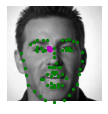

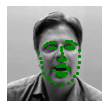

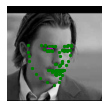

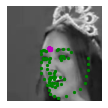

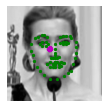

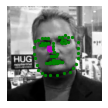

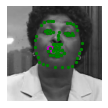

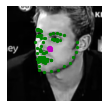

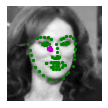

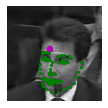

In [26]:
# visualize the output
# by default this shows a batch of 10 images
def visualize_output(test_images, test_outputs, gt_pts=None, batch_size=10):

    for i in range(batch_size):
        plt.figure(figsize=(20,10))
        ax = plt.subplot(1, batch_size, i+1)

        # un-transform the image data
        image = test_images[i].data   # get the image from it's wrapper
        image = image.numpy()   # convert to numpy array from a Tensor
        image = np.transpose(image, (1, 2, 0))   # transpose to go from torch to numpy image

        # un-transform the predicted key_pts data
        predicted_key_pts = test_outputs[i].data
        predicted_key_pts = predicted_key_pts.numpy()
        # undo normalization of keypoints  
        predicted_key_pts = predicted_key_pts*50.0+100
        
        # plot ground truth points for comparison, if they exist
        ground_truth_pts = None
        if gt_pts is not None:
            ground_truth_pts = gt_pts[i]         
            ground_truth_pts = ground_truth_pts*50.0+100
        
        # call show_all_keypoints
        show_all_keypoints(np.squeeze(image), predicted_key_pts, ground_truth_pts)
            
        plt.axis('off')

    plt.show()
    
# call it
visualize_output(test_images1, test_outputs1, gt_pts1)

## Training

In [28]:
import torch.optim as optim

criterion = nn.MSELoss()


optimizer = optim.Adam(params = net.parameters(), lr = 0.001) 
#optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.999)

In [29]:
def train_net(n_epochs):

    # prepare the net for training
    net.train()

    for epoch in range(n_epochs):  # loop over the dataset multiple times
        
        running_loss = 0.0

        # train on batches of data, assumes you already have train_loader
        for batch_i, data in enumerate(train_loader):
            # get the input images and their corresponding labels
            images = data['image']
            key_pts = data['keypoints']

            # flatten pts
            key_pts = key_pts.view(key_pts.size(0), -1)

            # convert variables to floats for regression loss
            key_pts = key_pts.type(torch.FloatTensor)
            images = images.type(torch.FloatTensor)

            # forward pass to get outputs
            output_pts = net(images)

            # calculate the loss between predicted and target keypoints
            loss = criterion(output_pts, key_pts)

            # zero the parameter (weight) gradients
            optimizer.zero_grad()
            
            # backward pass to calculate the weight gradients
            loss.backward()

            # update the weights
            optimizer.step()

            # print loss statistics
            # to convert loss into a scalar and add it to the running_loss, use .item()
            running_loss += loss.item()
            if batch_i % 10 == 9:    # print every 10 batches
                print('Epoch: {}, Batch: {}, Avg. Loss: {}'.format(epoch + 1, batch_i+1, running_loss/1000))
                running_loss = 0.0

    print('Finished Training')

In [30]:
# train your network
n_epochs = 5 # start small, and increase when you've decided on your model structure and hyperparams

train_net(n_epochs)

Epoch: 1, Batch: 10, Avg. Loss: 0.004072779282927513
Epoch: 1, Batch: 20, Avg. Loss: 0.0021386093497276306
Epoch: 1, Batch: 30, Avg. Loss: 0.002463847026228905
Epoch: 1, Batch: 40, Avg. Loss: 0.0022746723592281344
Epoch: 1, Batch: 50, Avg. Loss: 0.0022528225928544997
Epoch: 1, Batch: 60, Avg. Loss: 0.0021590812504291533
Epoch: 1, Batch: 70, Avg. Loss: 0.0025567231103777884
Epoch: 1, Batch: 80, Avg. Loss: 0.0018357738181948662
Epoch: 1, Batch: 90, Avg. Loss: 0.0033301852494478225
Epoch: 1, Batch: 100, Avg. Loss: 0.0018911734074354171
Epoch: 1, Batch: 110, Avg. Loss: 0.0016089977473020553
Epoch: 1, Batch: 120, Avg. Loss: 0.00198784551769495
Epoch: 1, Batch: 130, Avg. Loss: 0.0018651097938418388
Epoch: 1, Batch: 140, Avg. Loss: 0.0018102817237377166
Epoch: 1, Batch: 150, Avg. Loss: 0.0018065307438373565
Epoch: 1, Batch: 160, Avg. Loss: 0.001876206174492836
Epoch: 1, Batch: 170, Avg. Loss: 0.0018359547406435013
Epoch: 1, Batch: 180, Avg. Loss: 0.001914291501045227
Epoch: 1, Batch: 190, Avg

## Test data

See how your model performs on previously unseen, test data. We've already loaded and transformed this data, similar to the training data. Next, run your trained model on these images to see what kind of keypoints are produced. You should be able to see if your model is fitting each new face it sees, if the points are distributed randomly, or if the points have actually overfitted the training data and do not generalize.

In [31]:
# get a sample of test data again
test_images2, test_outputs2, gt_pts2 = net_sample_output()

print(test_images2.data.size())
print(test_outputs2.data.size())
print(gt_pts2.size())

torch.Size([10, 1, 224, 224])
torch.Size([10, 68, 2])
torch.Size([10, 68, 2])


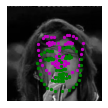

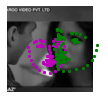

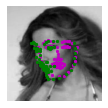

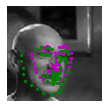

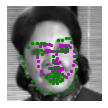

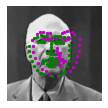

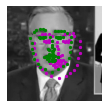

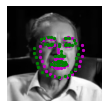

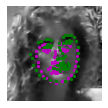

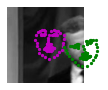

In [32]:
## Test
visualize_output(test_images2, test_outputs2, gt_pts2)

Once you've found a good model (or two), save your model so you can load it and use it later!

## Feature Visualization

Sometimes, neural networks are thought of as a black box, given some input, they learn to produce some output. CNN's are actually learning to recognize a variety of spatial patterns and you can visualize what each convolutional layer has been trained to recognize by looking at the weights that make up each convolutional kernel and applying those one at a time to a sample image. This technique is called feature visualization and it's useful for understanding the inner workings of a CNN.

[[ 0.13694048 -0.01097308 -0.2470506   0.14648865]
 [-0.23201337 -0.04564295 -0.07979026  0.12261731]
 [-0.2167603  -0.03551274 -0.17722006  0.1213337 ]
 [ 0.20054673 -0.08127302  0.03253031 -0.05155085]]
(4, 4)


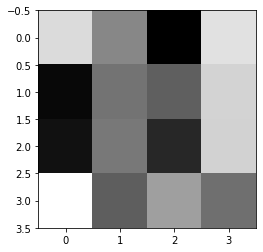

In [33]:
# Get the weights in the first conv layer, "conv1"
# if necessary, change this to reflect the name of your first conv layer
weights1 = net.conv_1.weight.data

w = weights1.numpy()

filter_index = 1

print(w[filter_index][0])
print(w[filter_index][0].shape)

# display the filter weights
plt.imshow(w[filter_index][0], cmap='gray')